athomeデータの物件に対してkmeans++法でクラスタリングするノートブック

因子分析は無し。


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import pyclustering.cluster.center_initializer as ci
import pyclustering.utils as utils
from sklearn import cluster
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [25]:
pd.set_option('display.max_columns', 500)

In [2]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term
    
    BIC = BIC*(-1)

    return(BIC, labels, m)

In [3]:
def checkClusterRecords(inshi_with_kmeans):
    """
    クラスタごとのデータ数を確認
    """

    inshi_with_kmeans["cluster_kmeans"] = inshi_with_kmeans["cluster_kmeans"].astype(int)
    for i in inshi_with_kmeans.groupby("cluster_kmeans"):
        row = i[1]
        print(str(i[0]),"|",len(row))

In [4]:
def df_normalise(df,colname):
    """
    標準化をする関数
    """
    theseries = df[colname]
    theseries = (theseries - theseries.mean()) / theseries.std()
    df[colname] = theseries
    return df

In [6]:
df = pd.read_csv(r"../data/src/ch4/athome_bunkyo.csv",usecols = ["物件番号","公開月","徒歩(分)","所在階","Area","賃料・価格","how_old"],dtype="str")
df = df[df["公開月"].str.contains("2015")].dropna()
df = df.drop_duplicates(subset = ["物件番号"])
del df["物件番号"], df["公開月"]
df["所在階"] = df["所在階"].replace('B1', '-1')
df = df.astype(float)
df.head(1)

,徒歩(分),賃料・価格,所在階,Area,how_old
40,9.0,65000.0,3.0,20.0,374.4


In [7]:
df.describe()

,徒歩(分),賃料・価格,所在階,Area,how_old
count,34395.000000,3.439500e+04,34395.000000,34395.000000,34395.000000
mean,5.799709,1.061917e+05,4.353336,32.676961,223.858847
std,3.298337,5.250877e+04,3.070677,35.366580,146.713637
min,1.000000,2.000000e+04,-1.000000,2.000000,-9.166667
25%,3.000000,7.500000e+04,2.000000,20.980000,112.633333
50%,5.000000,8.900000e+04,3.000000,26.090000,181.566667
75%,8.000000,1.280000e+05,6.000000,40.270000,325.700000
max,40.000000,1.800000e+06,24.000000,4812.000000,1401.133333


In [8]:
for name in ["徒歩(分)","所在階","Area","賃料・価格","how_old"]:
    df = df_normalise(df,name)
df.head(3)

,徒歩(分),賃料・価格,所在階,Area,how_old
40,0.970274,-0.784473,-0.440729,-0.358445,1.026088
41,1.273457,-0.327407,-0.766390,-0.122629,-0.744254
44,-1.152008,-0.727340,0.861916,-0.394637,0.818655


In [9]:
len(df)

34395

In [1]:
test_array = np.array([df["徒歩(分)"].tolist(),df["所在階"].tolist(),df["Area"].tolist(),df["how_old"].tolist(),df["賃料・価格"].tolist()], np.float).T

X = test_array  

ks = range(1,25)
           
# run 50 times kmeans and save each result in the KMeans object
KMeans = [cluster.KMeans(n_clusters = i, max_iter = 10000, init="k-means++").fit(X) for i in ks]

print("KMeans done")

NameError: name 'np' is not defined

In [11]:
# now run for each cluster the BIC computation
pre_BIC = 2668945
prelabel = []
prem = 0
bigcount = 0
BIClist = []
Score1 = []
Score2 = []
Score3 = []
for kmeansi in KMeans:
    BIC,label,m = compute_bic(kmeansi,X)
    BIClist.append(BIC)
    print(BIC)
    if 3 > bigcount:
        #print("test")
        if pre_BIC > BIC:
            pass
            #print(BIC,m)
        else:
            #print("test2")
            bigcount = bigcount + 1
            df["cluster_kmeans"] = 0
            num = df.shape[1]-1
            cluster = prelabel
            #クラスタ番号をデータフレームに付与。
            for n in range(0,len(cluster)):
                df.iat[n,num] = cluster[n]
            
            if bigcount == 1:
                Score1.append(df)
                Score1 = pd.concat(Score1)
                print(Score1["cluster_kmeans"].unique(),prem)

            elif bigcount == 2:
                Score2.append(df)
                Score2 = pd.concat(Score2)
                print(Score2["cluster_kmeans"].unique(),prem)
            
            elif bigcount == 3:
                Score3.append(df)
                Score3 = pd.concat(Score3)
                print(Score3["cluster_kmeans"].unique(),prem)

    #print(bigcount)
    pre_BIC = BIC
    prelabel = label
    prem = m
    
checkClusterRecords(Score1)
print("=======================================================================")
checkClusterRecords(Score2)

244050.79124732726
246591.94369186717
[0] 1
229321.29599882444
227822.2555432263
225381.82578342973
218647.02824417615
218497.88138915374
213243.85657928532
211613.13906199264
208738.1497535145
208556.94251340188
207125.16660501357
204257.31995374878
204030.54386294546
202600.44302944173
202942.47489452024
[ 1  3  2  5  7 13  9  6 12 11  8 14  0 10  4] 15
201989.50094934137
201424.1586478927
199698.295406848
197341.25801982518
197262.41962741278
196443.9921681286
194999.17007230286
194779.83088399062
0 | 34395
0 | 506
1 | 3494
2 | 2716
3 | 4997
4 | 2
5 | 4126
6 | 787
7 | 2301
8 | 4641
9 | 1684
10 | 111
11 | 2311
12 | 2220
13 | 2374
14 | 2125


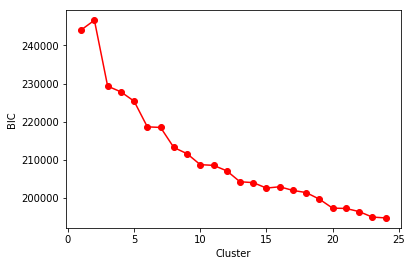

In [27]:
%matplotlib inline
theBIC = pd.DataFrame(BIClist,index = np.arange(1,25)).astype(int)
theBIC.to_csv(r"../data/dev//ch4thebic.csv")
plt.xlabel("Cluster")
plt.ylabel("BIC")
plt.plot(theBIC,'r-o')
plt.savefig(r"../data/dev/bic.png")

In [15]:
df = pd.read_csv(r"../data/src/ch4/athome_bunkyo.csv",dtype="str")
df = df[df["公開月"].str.contains("2015")].dropna(subset = [ ["徒歩(分)","所在階","Area","賃料・価格","how_old"]])
df = df.drop_duplicates(subset = ["物件番号"])
df["所在階"] = df["所在階"].replace('B1', '-1')
df[["賃料・価格","徒歩(分)","所在階","Area","how_old"]] = df[["賃料・価格","徒歩(分)","所在階","Area","how_old"]].astype(float)
df.head(1)

,Unnamed: 0,物件番号,種目名称,新築中古区分,都道府県,所在地名1,所在地名2,沿線名称,駅名称,徒歩(分),...,district,公開月,Months,how_old,under_20,20_30,30_40,40_50,50_60,above_60
40,40,1095977215,貸マンション,2.0,東京都,文京区,本駒込５丁目,ＪＲ山手線,駒込,9.0,...,本駒込,201512,2015-12-01,374.4,1,0,0,0,0,0


In [19]:
Score2 = Score2.rename(columns = {"cluster_kmeans_18":"cluster_kmeans_15","徒歩(分)":"toho_norm","所在階":"syozai_norm","Area":"Area_norm","賃料・価格":"price_norm","how_old":"how_old_norm"})
df2 = pd.concat([df, Score2],  axis=1, join_axes=[df.index])
df2.head(2)

,Unnamed: 0,物件番号,種目名称,新築中古区分,都道府県,所在地名1,所在地名2,沿線名称,駅名称,徒歩(分),...,30_40,40_50,50_60,above_60,toho_norm,price_norm,syozai_norm,Area_norm,how_old_norm,cluster_kmeans_15
40,40,1095977215,貸マンション,2.0,東京都,文京区,本駒込５丁目,ＪＲ山手線,駒込,9.0,...,0,0,0,0,0.970274,-0.784473,-0.440729,-0.358445,1.026088,1
41,41,1035190112,貸マンション,2.0,東京都,文京区,後楽２丁目,東京メトロ丸ノ内線,後楽園,10.0,...,0,0,0,0,1.273457,-0.327407,-0.766390,-0.122629,-0.744254,3


In [20]:
df2.to_csv(r"../data/dev/ch4/athome_bunkyo_rent_k15.csv")

In [26]:
k18des = df2.groupby("cluster_kmeans_15")[["徒歩(分)","所在階","Area","賃料・価格","how_old"]].describe()
k18des.to_csv(r"../data/dev/athome_bunkyo_rent_k15des.csv")
k18des

徒歩(分)                                                 \
                    count       mean       std   min    25%   50%    75%   
cluster_kmeans_15                                                          
0                   506.0  18.169960  4.365795  14.0  15.00  17.0  20.00   
1                  3494.0   9.134803  1.686027   7.0   8.00   9.0  10.00   
2                  2716.0   2.791605  1.458328   1.0   1.00   3.0   4.00   
3                  4997.0   7.999200  1.660785   6.0   7.00   8.0   9.00   
4                     2.0   5.500000  4.949747   2.0   3.75   5.5   7.25   
5                  4126.0   3.951285  1.562221   1.0   3.00   4.0   5.00   
6                   787.0   5.819568  2.802302   1.0   3.00   6.0   8.00   
7                  2301.0   4.681443  1.992322   1.0   3.00   5.0   6.00   
8                  4641.0   3.240250  1.432318   1.0   2.00   3.0   5.00   
9                  1684.0   8.811164  1.743837   6.0   8.00   9.0  10.00   
10                  111.0   4.630631  1.920833   1.0   3.00   4.0   5.00   
11                 2311.0   3.450022  1.464438   1.0   2.00   4.0   5.00   
12                 2220.0   5.509910  2.103108   1.0   4.00   6.0   7.00   
13                 2374.0   8.264532  1.821336   6.0   7.00   8.0  10.00   
14                 2125.0   4.204706  2.313470   1.0   2.00   4.0   6.00   

                            所在階                                               \
                    max   count       mean       std  min   25%   50%    75%   
cluster_kmeans_15                                                              
0                  40.0   506.0   3.049407  2.076633 -1.0  2.00   2.0   4.00   
1                  15.0  3494.0   2.665999  1.357742 -1.0  2.00   2.0   3.00   
2                   5.0  2716.0   8.236009  1.809299  5.0  7.00   8.0  10.00   
3                  14.0  4997.0   2.691415  1.286762 -1.0  2.00   3.0   4.00   
4                   9.0     2.0   5.500000  4.949747  2.0  3.75   5.5   7.25   
5                   6.0  4126.0   2.748667  1.437200 -1.0  2.00   2.0   4.00   
6                  18.0   787.0   4.520966  2.640072 -1.0  2.00   4.0   6.00   
7                  12.0  2301.0   4.246415  2.136767  1.0  3.00   4.0   6.00   
8                   5.0  4641.0   2.820513  1.315973  1.0  2.00   3.0   4.00   
9                  17.0  1684.0   3.195962  1.617516 -1.0  2.00   3.0   4.00   
10                 10.0   111.0   9.855856  6.180390  1.0  2.00  11.0  14.00   
11                  7.0  2311.0   4.016876  1.816988 -1.0  3.00   4.0   6.00   
12                 13.0  2220.0   3.079279  1.656109 -1.0  2.00   3.0   4.00   
13                 15.0  2374.0   8.136057  1.859481  6.0  7.00   8.0   9.00   
14                 13.0  2125.0  11.000471  2.272305  7.0  9.00  11.0  12.00   

                           Area                                                \
                    max   count         mean          std      min        25%   
cluster_kmeans_15                                                               
0                  12.0   506.0    23.350672     9.667678     9.08    18.1475   
1                   8.0  3494.0    25.242748     9.505178     7.40    18.0000   
2                  15.0  2716.0    24.841583     6.215215    10.00    20.6700   
3                   5.0  4997.0    24.086746     5.375512     3.01    20.5200   
4                   9.0     2.0  4006.000000  1139.856131  3200.00  3603.0000   
5                   8.0  4126.0    23.177121     6.960517     9.44    17.9600   
6                  12.0   787.0    85.335578    18.660356    51.45    72.1800   
7                  13.0  2301.0    51.259357    11.312007     6.00    43.5400   
8                   6.0  4641.0    24.452874     5.477474     9.70    20.7400   
9                   8.0  1684.0    51.222262    11.852582    28.47    42.2800   
10                 21.0   111.0   128.807928    45.029282    23.08    74.5000   
11                  7.0  2311.0    47.725439     9.791235    20.23    40.540

## OLSの比較

In [22]:
df2.head(2)

,Unnamed: 0,物件番号,種目名称,新築中古区分,都道府県,所在地名1,所在地名2,沿線名称,駅名称,徒歩(分),...,30_40,40_50,50_60,above_60,toho_norm,price_norm,syozai_norm,Area_norm,how_old_norm,cluster_kmeans_15
40,40,1095977215,貸マンション,2.0,東京都,文京区,本駒込５丁目,ＪＲ山手線,駒込,9.0,...,0,0,0,0,0.970274,-0.784473,-0.440729,-0.358445,1.026088,1
41,41,1035190112,貸マンション,2.0,東京都,文京区,後楽２丁目,東京メトロ丸ノ内線,後楽園,10.0,...,0,0,0,0,1.273457,-0.327407,-0.766390,-0.122629,-0.744254,3


In [23]:
#全データ
import statsmodels.api as sm

X = df2[["徒歩(分)","所在階","how_old"]]
X = sm.add_constant(X)
Y = df2["平米単価"].astype(float)
model = sm.OLS(Y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   平米単価   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     2684.
Date:                Mon, 31 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:59:39   Log-Likelihood:            -2.6979e+05
No. Observations:               34395   AIC:                         5.396e+05
Df Residuals:                   34391   BIC:                         5.396e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3708.6805     10.663    347.809      0.0

In [24]:
for cl_num13 in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("cl_n15_cl_{}".format(cl_num13))
    df_olsee = df2[df2["cluster_kmeans_15"] == cl_num13]
    X = df_olsee[["徒歩(分)","所在階","how_old"]]
    X = sm.add_constant(X)
    Y = df_olsee["平米単価"].astype(float)
    model = sm.OLS(Y, X)
    result = model.fit()
    print(result.summary())

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cl_n15_cl_0
                            OLS Regression Results                            
Dep. Variable:                   平米単価   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     48.95
Date:                Mon, 31 Dec 2018   Prob (F-statistic):           9.17e-28
Time:                        15:59:46   Log-Likelihood:                -3889.2
No. Observations:                 506   AIC:                             7786.
Df Residuals:                     502   BIC:                             7803.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

C:\Users\mymt_akck\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  "samples were given." % int(n), ValueWarning)
C:\Users\mymt_akck\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1549: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\mymt_akck\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1550: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
C:\Users\mymt_akck\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
C:\Users\mymt_akck\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_r

                            OLS Regression Results                            
Dep. Variable:                   平米単価   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Mon, 31 Dec 2018   Prob (F-statistic):                nan
Time:                        15:59:47   Log-Likelihood:                 60.786
No. Observations:                   2   AIC:                            -117.6
Df Residuals:                       0   BIC:                            -120.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1137        inf          0        n

                            OLS Regression Results                            
Dep. Variable:                   平米単価   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     231.4
Date:                Mon, 31 Dec 2018   Prob (F-statistic):          1.12e-125
Time:                        15:59:47   Log-Likelihood:                -12429.
No. Observations:                1684   AIC:                         2.487e+04
Df Residuals:                    1680   BIC:                         2.489e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3386.0389     54.148     62.533      0.0